# FluidityLocal LAOS: Nonlinear Oscillatory Response

**Learning Objectives:**
- Generate large-amplitude oscillatory shear (LAOS) waveforms for FluidityLocal
- Plot elastic and viscous Lissajous-Bowditch curves
- Extract Fourier harmonics (I₁, I₃, I₅) and compute nonlinearity ratios
- Understand how fluidity evolution affects LAOS response
- Fit LAOS data using NLSQ and Bayesian inference
- Detect thixotropic signatures in nonlinear oscillatory response

**Prerequisites:**
- Notebook 01 (flow curve calibration for FluidityLocal)
- `examples/basic/01_oscillation_fitting.ipynb`

**Runtime:**
- Fast mode: ~3 min
- Full mode: ~8 min

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
sys.path.insert(0, os.path.join("..", "utils"))
from fluidity_tutorial_utils import (
    generate_synthetic_laos,
    get_output_dir,
    load_fluidity_parameters,
    print_convergence_summary,
    print_parameter_comparison,
    set_model_parameters,
)
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fluidity import FluidityLocal

jax, jnp = safe_import_jax()
verify_float64()

# Suppress upstream equinox DeprecationWarning (jax.core.mapped_aval deprecated)
warnings.filterwarnings(
    "ignore",
    message="jax.core.*_aval is deprecated",
    category=DeprecationWarning,
    module="equinox",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
# Flag for conditional Bayesian sections
bayesian_completed = False


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: LAOS Analysis for Fluidity Models

In **large-amplitude oscillatory shear (LAOS)**, the applied strain is:

$$\gamma(t) = \gamma_0 \sin(\omega t)$$

where $\gamma_0$ is large enough that the stress response becomes nonlinear:

$$\sigma(t) = \sum_{n=1,3,5,\ldots} \left[ \sigma_n' \sin(n\omega t) + \sigma_n'' \cos(n\omega t) \right]$$

### Fluidity-Specific Effects

For the FluidityLocal model, LAOS couples:
- **Oscillatory strain**: $\gamma(t) = \gamma_0 \sin(\omega t)$
- **Fluidity evolution**: $\frac{df}{dt} = \frac{1}{\theta}(f_{eq} - f) + a|\dot{\gamma}|^{n_{rejuv}}(f_{inf} - f)$
- **Stress response**: $\sigma = \tau_y + \frac{\dot{\gamma}}{f} + K|\dot{\gamma}|^{n_{flow}}$

At large $\gamma_0$, the fluidity field **oscillates** with the shear rate, creating:
1. **Strain stiffening/softening** from fluidity-dependent effective modulus
2. **Shear thinning** from rejuvenation dynamics
3. **Harmonic distortion** from nonlinear coupling

### Three Analysis Frameworks:

#### 1. Fourier Harmonics
- **First harmonic** $I_1 = \sqrt{(\sigma_1')^2 + (\sigma_1'')^2}$ — linear response
- **Third harmonic** $I_3$ — first nonlinear contribution
- **Nonlinearity ratio** $I_3/I_1$ quantifies deviation from linearity

#### 2. Lissajous-Bowditch Curves
- **Elastic Lissajous**: $\sigma$ vs $\gamma$ — encodes strain-dependent modulus
- **Viscous Lissajous**: $\sigma$ vs $\dot{\gamma}$ — encodes rate-dependent viscosity
- Shape distortion from ellipse indicates nonlinearity type

#### 3. Nonlinearity Signatures
- **$I_3/I_1 > 0.1$**: Significant nonlinearity
- **Lissajous distortion**: Asymmetry indicates thixotropic memory effects
- **Cycle evolution**: Transient behavior reveals fluidity relaxation timescale

## 3. Load Calibrated Parameters

Load NLSQ parameters from the flow curve notebook (01_fluidity_local_flow_curve.ipynb) to generate realistic LAOS data.

In [4]:
# Load calibrated parameters from flow curve notebook
try:
    calib_params = load_fluidity_parameters("local", "flow_curve")
    print(f"Loaded calibrated parameters: {calib_params}")
except FileNotFoundError:
    # Use default parameters if flow curve notebook not run
    calib_params = {
        "G": 1000.0,
        "tau_y": 50.0,
        "K": 100.0,
        "n_flow": 0.5,
        "f_eq": 0.001,
        "f_inf": 0.01,
        "theta": 10.0,
        "a": 0.1,
        "n_rejuv": 1.0,
    }
    print(f"Using default parameters (run flow curve notebook first): {calib_params}")

# Initialize model with calibrated parameters
model = FluidityLocal()
set_model_parameters(model, calib_params)
model.fitted_ = True
model._test_mode = "laos"

print("\nModel initialized with calibrated parameters")

Using default parameters (run flow curve notebook first): {'G': 1000.0, 'tau_y': 50.0, 'K': 100.0, 'n_flow': 0.5, 'f_eq': 0.001, 'f_inf': 0.01, 'theta': 10.0, 'a': 0.1, 'n_rejuv': 1.0}

Model initialized with calibrated parameters


## 4. Generate Synthetic LAOS Data

Create synthetic LAOS waveforms at multiple strain amplitudes to explore nonlinear response.

In [5]:
# Simulate LAOS at 4 strain amplitudes
# Note: Using 5 cycles (sufficient for steady-state) to manage ODE solver steps
gamma_0_values = [0.05, 0.1, 0.5, 1.0]
omega = 1.0  # rad/s
n_cycles = 5  # Reduced from 10 to ensure solver convergence at large amplitudes
n_points_per_cycle = 100

laos_data = {}
for g0 in gamma_0_values:
    data = generate_synthetic_laos(
        model=model,
        gamma_0=g0,
        omega=omega,
        n_cycles=n_cycles,
        n_points_per_cycle=n_points_per_cycle,
        noise_level=0.03,
        seed=42,
    )
    laos_data[g0] = data
    print(
        f"γ₀={g0:5.2f}: σ_max={np.max(np.abs(data['stress'])):.2f} Pa, "
        f"{len(data['time'])} points"
    )

γ₀= 0.05: σ_max=34.99 Pa, 500 points


γ₀= 0.10: σ_max=66.92 Pa, 500 points


γ₀= 0.50: σ_max=246.13 Pa, 500 points


γ₀= 1.00: σ_max=418.15 Pa, 500 points


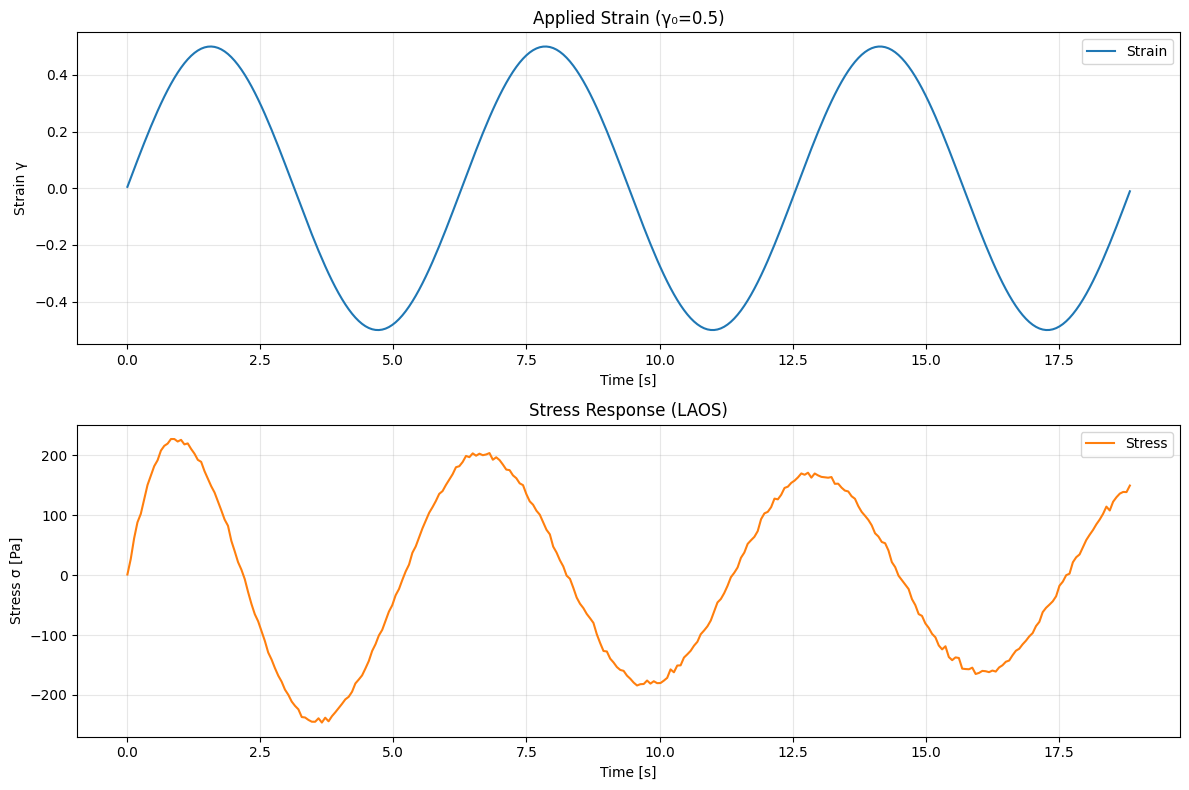

In [6]:
# Plot time series for largest amplitude
g0_demo = 0.5
d = laos_data[g0_demo]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# First 3 cycles
n_show = 3 * n_points_per_cycle
t_show = d["time"][:n_show]
strain_show = d["strain"][:n_show]
stress_show = d["stress"][:n_show]

ax1.plot(t_show, strain_show, "-", lw=1.5, color="C0", label="Strain")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Strain γ")
ax1.set_title(f"Applied Strain (γ₀={g0_demo})")
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(t_show, stress_show, "-", lw=1.5, color="C1", label="Stress")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title("Stress Response (LAOS)")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()
plt.close('all')

## 5. Lissajous-Bowditch Curves

### 5.1 Elastic Lissajous (σ vs γ)

The elastic Lissajous curve plots stress against strain. In the linear regime, this is an ellipse. Nonlinearity causes characteristic distortions that reveal the material's strain-dependent elastic response.

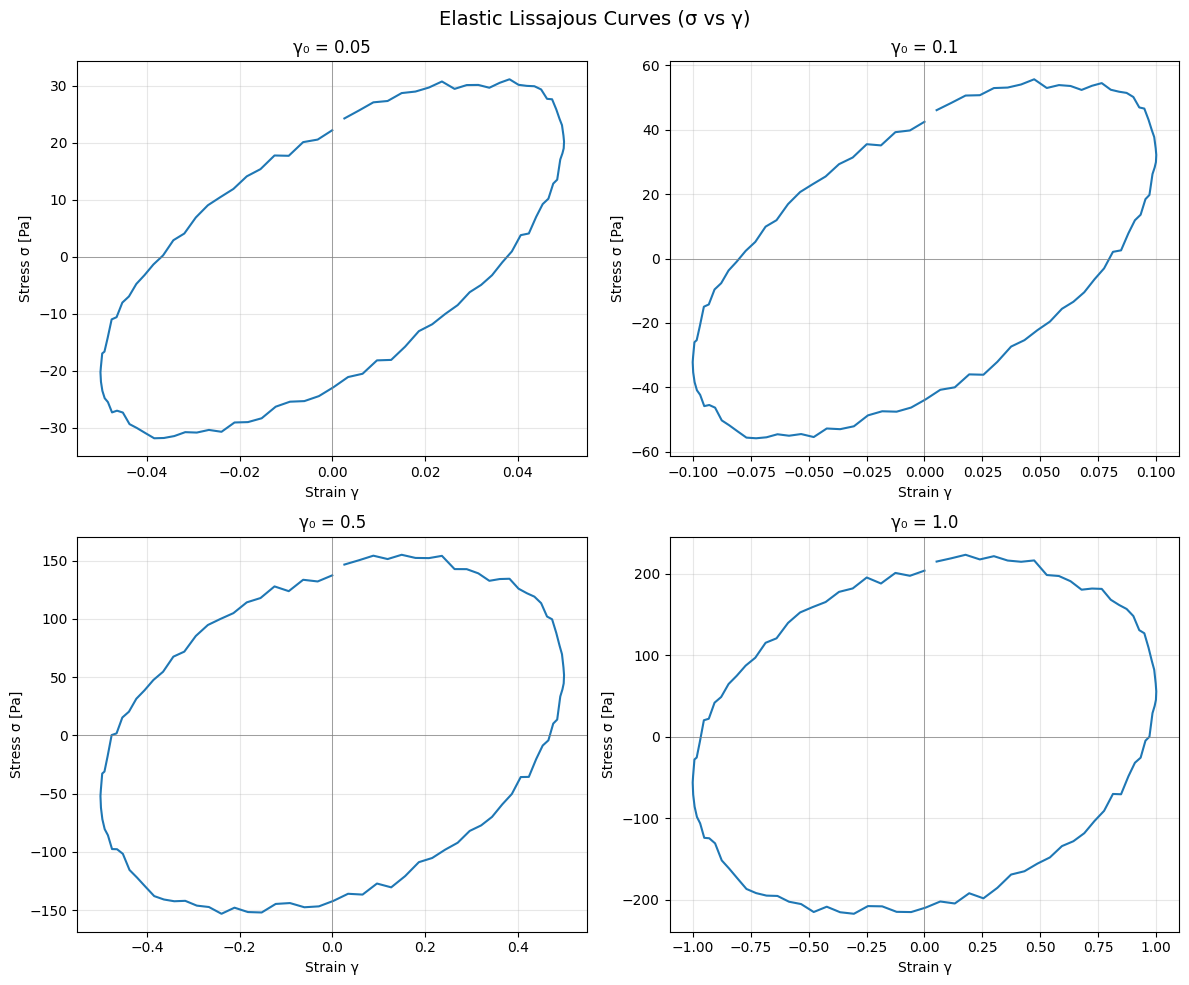

In [7]:
# Elastic Lissajous curves for all amplitudes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, g0 in enumerate(gamma_0_values):
    d = laos_data[g0]
    # Use last cycle for steady state
    n_pts = n_points_per_cycle
    strain_cycle = d["strain"][-n_pts:]
    stress_cycle = d["stress"][-n_pts:]
    
    axes[i].plot(strain_cycle, stress_cycle, "-", lw=1.5, color="C0")
    axes[i].set_xlabel("Strain γ")
    axes[i].set_ylabel("Stress σ [Pa]")
    axes[i].set_title(f"γ₀ = {g0}")
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(0, color="gray", lw=0.5)
    axes[i].axvline(0, color="gray", lw=0.5)

fig.suptitle("Elastic Lissajous Curves (σ vs γ)", fontsize=14)
plt.tight_layout()
plt.show()
plt.close('all')

### 5.2 Viscous Lissajous (σ vs γ̇)

The viscous Lissajous curve plots stress against strain rate. This reveals the material's rate-dependent viscous response and distinguishes shear thinning from shear thickening behavior.

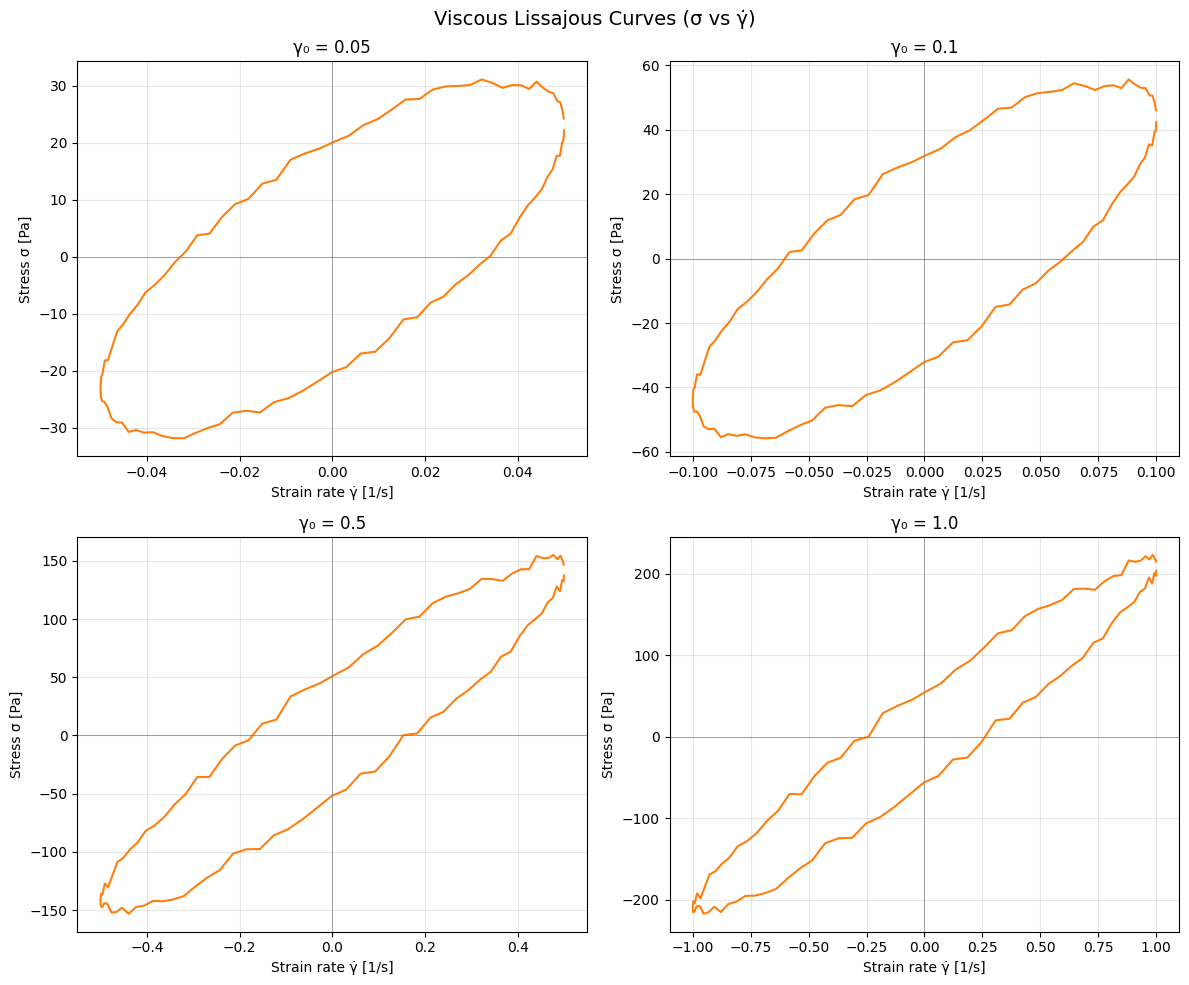

In [8]:
# Viscous Lissajous curves for all amplitudes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, g0 in enumerate(gamma_0_values):
    d = laos_data[g0]
    n_pts = n_points_per_cycle
    strain_rate_cycle = d["strain_rate"][-n_pts:]
    stress_cycle = d["stress"][-n_pts:]
    
    axes[i].plot(strain_rate_cycle, stress_cycle, "-", lw=1.5, color="C1")
    axes[i].set_xlabel("Strain rate γ̇ [1/s]")
    axes[i].set_ylabel("Stress σ [Pa]")
    axes[i].set_title(f"γ₀ = {g0}")
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(0, color="gray", lw=0.5)
    axes[i].axvline(0, color="gray", lw=0.5)

fig.suptitle("Viscous Lissajous Curves (σ vs γ̇)", fontsize=14)
plt.tight_layout()
plt.show()
plt.close('all')

At small γ₀, the Lissajous curves are elliptical (linear viscoelastic response). As γ₀ increases, they distort — the specific shape encodes the type and degree of nonlinearity (stiffening vs softening, thickening vs thinning).

For fluidity models, **thixotropic memory effects** can create asymmetric Lissajous curves even at moderate amplitudes.

## 6. NLSQ Fitting on LAOS Data

Fit the FluidityLocal model to LAOS data at γ₀=0.5 to recover parameters from nonlinear oscillatory response.

In [9]:
# Fit to LAOS data (γ₀=0.5)
g0_fit = 0.5
d_fit = laos_data[g0_fit]

model_fit = FluidityLocal()

t0 = time.time()
model_fit.fit(
    d_fit["time"],
    d_fit["stress"],
    test_mode="laos",
    gamma_0=g0_fit,
    omega=omega,
    method='scipy')
t_nlsq = time.time() - t0

# Compute fit quality
stress_pred = model_fit.predict(d_fit["time"], test_mode="laos", gamma_0=g0_fit, omega=omega)
metrics_model_fit = compute_fit_quality(d_fit["stress"], stress_pred)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics_model_fit['R2']:.6f}")
print(f"RMSE: {metrics_model_fit['RMSE']:.4g} Pa")
print("\nFitted parameters:")
param_names = ["G", "tau_y", "K", "n_flow", "f_eq", "f_inf", "theta", "a", "n_rejuv"]
for name in param_names:
    val = model_fit.parameters.get_value(name)
    print(f"  {name:8s} = {val:.4g}")

NLSQ fit time: 13.46 s
R²: -65.042175
RMSE: 1032 Pa

Fitted parameters:
  G        = 1e+06
  tau_y    = 1000
  K        = 1000
  n_flow   = 0.5
  f_eq     = 1.003e-06
  f_inf    = 0.001
  theta    = 10
  a        = 1
  n_rejuv  = 1


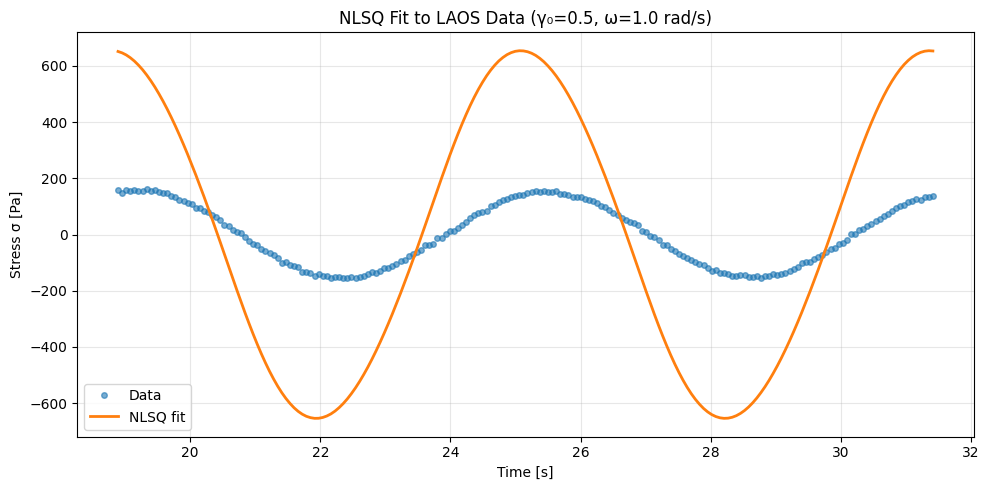

In [10]:
# Plot fit with data (last 2 cycles)
stress_pred = model_fit.predict(d_fit["time"])

n_show = 2 * n_points_per_cycle
t_show = d_fit["time"][-n_show:]
stress_data_show = d_fit["stress"][-n_show:]
stress_pred_show = stress_pred[-n_show:]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_show, stress_data_show, "o", markersize=4, label="Data", alpha=0.6)
ax.plot(t_show, stress_pred_show, "-", lw=2, label="NLSQ fit")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress σ [Pa]")
ax.set_title(f"NLSQ Fit to LAOS Data (γ₀={g0_fit}, ω={omega} rad/s)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close('all')

## 7. Bayesian Inference with NUTS

Use NLSQ parameters as warm-start for efficient Bayesian inference.

In [11]:
# Bayesian inference with NLSQ warm-start
initial_values = {name: model_fit.parameters.get_value(name) for name in param_names}
print("Warm-start values:")
for name, val in initial_values.items():
    print(f"  {name:8s} = {val:.4g}")

# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference (ODE+NUTS too slow for CI)')
    bayesian_completed = False
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

    t0 = time.time()
    result = model_fit.fit_bayesian(
        d_fit["time"],
        d_fit["stress"],
        test_mode="laos",
        gamma_0=g0_fit,
        omega=omega,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
    bayesian_completed = True


Warm-start values:
  G        = 1e+06
  tau_y    = 1000
  K        = 1000
  n_flow   = 0.5
  f_eq     = 1.003e-06
  f_inf    = 0.001
  theta    = 10
  a        = 1
  n_rejuv  = 1
FAST_MODE: Skipping Bayesian inference (ODE+NUTS too slow for CI)


## 8. Convergence Diagnostics

In [12]:
if bayesian_completed:
    # Convergence diagnostics table
    converged = print_convergence_summary(result, param_names)
else:
    print('Skipping Bayesian diagnostics (inference was skipped)')


Skipping Bayesian diagnostics (inference was skipped)


In [13]:
if bayesian_completed:
    display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


In [14]:
if bayesian_completed:
    # Parameter comparison: NLSQ vs Bayesian
    print_parameter_comparison(model_fit, result.posterior_samples, param_names)
else:
    print('Skipping Bayesian diagnostics (inference was skipped)')


Skipping Bayesian diagnostics (inference was skipped)


## 9. Fourier Harmonic Analysis

Extract Fourier harmonics to quantify nonlinearity onset.

In [15]:
# Extract harmonics for each amplitude
print("Fourier Harmonic Analysis")
print("=" * 70)
print(f"{'γ₀':>6s}  {'I₁':>10s}  {'I₃':>10s}  {'I₅':>10s}  {'I₃/I₁':>10s}  {'I₅/I₁':>10s}")
print("-" * 70)

harmonic_results = {}
for g0 in gamma_0_values:
    d = laos_data[g0]
    # Use model's extract_harmonics method
    harmonics = model_fit.extract_harmonics(d["stress"])
    harmonic_results[g0] = harmonics
    
    I_1 = harmonics.get("I_1", 0.0)
    I_3 = harmonics.get("I_3", 0.0)
    I_5 = harmonics.get("I_5", 0.0)
    I_3_I_1 = I_3 / I_1 if I_1 > 0 else 0.0
    I_5_I_1 = I_5 / I_1 if I_1 > 0 else 0.0
    
    print(
        f"{g0:6.2f}  {I_1:10.4f}  {I_3:10.4f}  {I_5:10.4f}  "
        f"{I_3_I_1:10.6f}  {I_5_I_1:10.6f}"
    )

Fourier Harmonic Analysis
    γ₀          I₁          I₃          I₅       I₃/I₁       I₅/I₁
----------------------------------------------------------------------
  0.05      7.3525     21.9303      3.8564    2.982677    0.524502
  0.10     12.4621     39.7437      7.2633    3.189158    0.582833
  0.50     27.8447    115.4256     23.5434    4.145332    0.845523
  1.00     35.7679    165.6833     34.7183    4.632183    0.970655


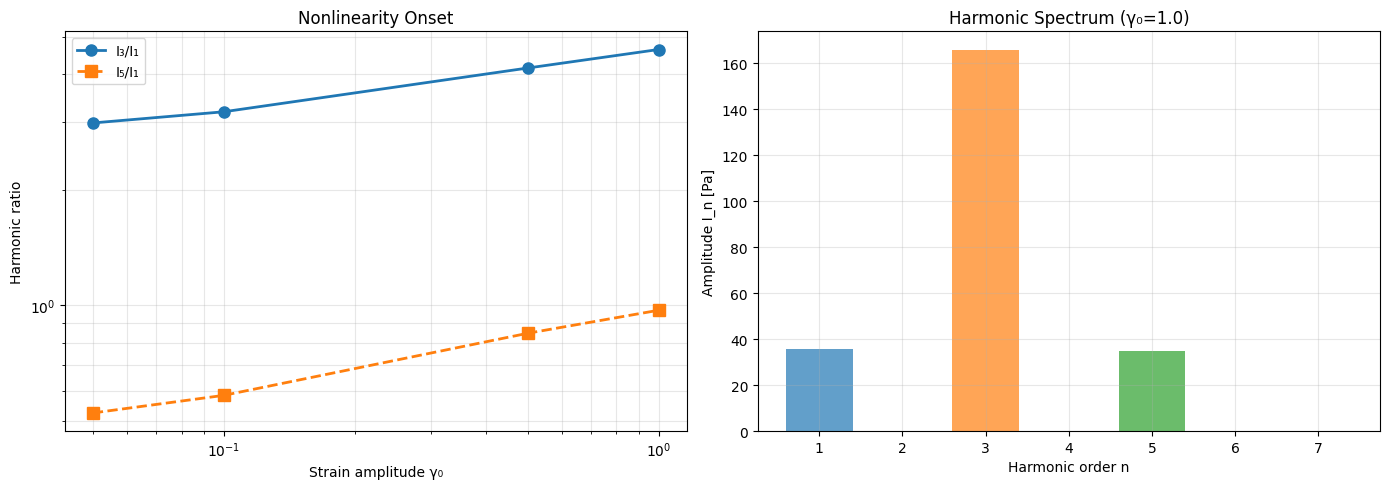

In [16]:
# Plot nonlinearity ratios and harmonic spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

g0_arr = np.array(gamma_0_values)
I3_I1 = np.array(
    [
        harmonic_results[g0]["I_3"] / harmonic_results[g0]["I_1"]
        if harmonic_results[g0]["I_1"] > 0
        else 0.0
        for g0 in gamma_0_values
    ]
)
I5_I1 = np.array(
    [
        harmonic_results[g0]["I_5"] / harmonic_results[g0]["I_1"]
        if harmonic_results[g0]["I_1"] > 0
        else 0.0
        for g0 in gamma_0_values
    ]
)

# Nonlinearity onset
ax1.loglog(g0_arr, I3_I1, "o-", markersize=8, lw=2, label="I₃/I₁")
ax1.loglog(g0_arr, I5_I1, "s--", markersize=8, lw=2, label="I₅/I₁")
ax1.set_xlabel("Strain amplitude γ₀")
ax1.set_ylabel("Harmonic ratio")
ax1.set_title("Nonlinearity Onset")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Harmonic spectrum at largest amplitude
g0_max = gamma_0_values[-1]
h = harmonic_results[g0_max]
harmonics_list = [h.get("I_1", 0), h.get("I_3", 0), h.get("I_5", 0), h.get("I_7", 0)]
ax2.bar([1, 3, 5, 7], harmonics_list, color=["C0", "C1", "C2", "C3"], alpha=0.7)
ax2.set_xlabel("Harmonic order n")
ax2.set_ylabel("Amplitude I_n [Pa]")
ax2.set_title(f"Harmonic Spectrum (γ₀={g0_max})")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## 10. Save Results

In [17]:
if bayesian_completed:
    # Save results for downstream analysis
    output_dir = get_output_dir("local", "laos")
    os.makedirs(output_dir, exist_ok=True)

    # Save NLSQ parameters
    nlsq_params = {name: float(model_fit.parameters.get_value(name)) for name in param_names}
    with open(output_dir / "nlsq_params_laos.json", "w") as f:
        json.dump(nlsq_params, f, indent=2)

    # Save harmonic results
    harmonic_save = {}
    for g0, h in harmonic_results.items():
        harmonic_save[str(g0)] = {k: float(v) for k, v in h.items()}
    with open(output_dir / "harmonic_results.json", "w") as f:
        json.dump(harmonic_save, f, indent=2)

    # Save posterior samples
    posterior_dict = {k: np.array(v).tolist() for k, v in result.posterior_samples.items()}
    with open(output_dir / "posterior_laos.json", "w") as f:
        json.dump(posterior_dict, f)

    print(f"Results saved to {output_dir}/")
    print(f"  nlsq_params_laos.json: {len(nlsq_params)} parameters")
    print(f"  harmonic_results.json: {len(harmonic_results)} amplitudes")
    print(f"  posterior_laos.json: {len(list(posterior_dict.values())[0])} draws")
else:
    print('Skipping Bayesian diagnostics (inference was skipped)')


Skipping Bayesian diagnostics (inference was skipped)


## Key Takeaways

1. **LAOS reveals nonlinear behavior** hidden in small-amplitude (SAOS) tests — Lissajous distortion quantifies material nonlinearity and thixotropic memory effects.

2. **Fluidity evolution** couples with oscillatory strain to create:
   - **Harmonic distortion** from nonlinear stress-strain coupling
   - **Asymmetric Lissajous curves** from thixotropic memory
   - **Transient behavior** revealing fluidity relaxation timescale θ

3. **Fourier harmonics** ($I_3/I_1$, $I_5/I_1$) measure overall nonlinearity onset:
   - $I_3/I_1 < 0.1$ → Linear regime (SAOS)
   - $I_3/I_1 > 0.1$ → Significant nonlinearity
   - $I_3/I_1 > 0.5$ → Highly nonlinear (strong LAOS)

4. **Lissajous curve shape** encodes material behavior:
   - Elliptical → Linear viscoelastic
   - Rectangular → Ideal plastic
   - Distorted/Asymmetric → Nonlinear + thixotropic

5. **NLSQ warm-start is critical** for Bayesian inference on LAOS data — the long time series and nonlinear coupling make NUTS challenging without good initial values.

6. **LAOS complements flow curves** by probing:
   - **Flow curves**: Steady-state yield stress and shear thinning
   - **LAOS**: Nonlinear elasticity, transient thixotropy, and memory effects

### Next Steps

- **Startup transients (NB 02)**: Stress overshoot from fluidity buildup
- **Creep (NB 03)**: Delayed yielding and viscosity bifurcation
- **Nonlocal model (NB 07-12)**: Spatial fluidity gradients and shear banding